# Problem 6: Multilayer Perceptron

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from utils.activations import softmax, sigmoid
from utils.data_parser import data_split_train_test
np.random.seed(1)

#define constants
num_class = 4 # no of classes
hidden_layer_units = 25  #number of units in the hidden layer
epochs = 200  #number of iterations
alpha = 0.001 #learning rate 


## DataSource
We split the provided data into 2 sets: training set and validation set with the ration 8:2

In [2]:
x = pd.read_csv(os.path.join('data','train_data.csv'), header=None).add_prefix('Feature_')
y = pd.read_csv(os.path.join('data', 'train_labels.csv'), header=None, names=["Label_0", "Label_1", "Label_2", "Label_3"])
X, Y, X_v, Y_v = data_split_train_test(x, y)
X_train = X.values   #training samples
Y_train = Y.values   #training labels

m, n = X_train.shape  #samples x features
X_Validate = X_v.values  #validation samples
Y_Validate = Y_v.values  #validation labels


## Layer, Forward Propagation, and Backward Propagation
We then implement Layer, Forward Propagation, and Back Propagation as follow
<img align="left" src="./system.png"     style=" width:380px; padding: 10px; " >


In [3]:
def Layer(A_in, W, B, g):
    """
    :param A_in: shape(m,n) - input data
    :param W: shape(feature,units) - weight matrix, n0 feature  x units, 
    :param b: shape(units,1) - bias vector, n0 units x 1
    :param g: activation function(e.g sigmoid, relu, softmax, ...)
    :return:
    Z - linear regression
    A_out: shape(m, units): output data - m x units
    """
    Z = np.dot(A_in, W) + B
    A_out = g(Z)
    return Z,A_out

In [4]:
def compute_forward_prop(x, W1, b1, W2, b2):
    z1, a1 = Layer(x, W1, b1, sigmoid)  #hidden layer [1] with sigmoid activation
    z2, a2 = Layer(a1, W2, b2, softmax) #output layer [2] with softmax activation
    return z1, a1, z2, a2

Back-propagation is computed by the formulas:
$$dz^{[2]}=a^{[2]} - Ytrain$$
$$dW^{[2]}=a^{[1]T}\cdot dz^{[2]}$$
$$db^{[2]}=dz^{[2]}$$
$$dz^{[1]}=dz^{[2]}  W^{[2]T}$$
$$dW^{[1]}=X^{T}\cdot dz^{[1]}*(z^{[1]})^{'}$$
$$db^{[1]}=dz^{[1]}*(z^{[1]})^{'}$$

In [5]:
def sigmoid_derivative(x): 
    return sigmoid(x) * (1 - sigmoid(x))

def compute_backward_prop(Z1, A1, A2, W2,X, Y): 
    dz2 = A2 - Y
    dW2 = np.dot(A1.T,dz2)
    db2 = dz2
    dz1 = np.dot(dz2,W2.T)
    db1 = dz1 * sigmoid_derivative(Z1)
    dW1 = np.dot(X.T,dz1 * sigmoid_derivative(Z1))
    return db1, dW1, db2, dW2

## Gradient descent 
Then, these values from back-prop will be fed into gradient descent algorithm to re-calculate the weights and bias, so that the system can minimize the cost function:
$$W^{[1]} = W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} = b^{[1]} - \alpha db^{[1]}$$
$$W^{[2]} = W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} = b^{[2]} - \alpha db^{[2]}$$

In [6]:
def update_model_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha_):
    W1 = W1 - alpha_ * dW1
    W2 = W2 - alpha_ * dW2
    b1 = b1 - alpha_ * db1.sum(axis=0)
    b2 = b2 - alpha_ * db2.sum(axis=0)
    return b1, W1, b2, W2

## Cost function
Cost function is defined by the average of square of error function
$$Cost = \frac{1}{m}\sum_{i=0}^{m}(\hat{y}-y)^2$$

In [7]:
def compute_cost(y_hat, y):
    return np.mean(np.square(y_hat - y))

## Initialize model parameters
The model parameters are intialized randomly as follow:

In [8]:

def initialize_model_params():
    W1 = np.random.randn(n, hidden_layer_units)
    b1 = np.random.randn(hidden_layer_units)
    W2 = np.random.randn(hidden_layer_units, num_class)
    b2 = np.random.randn(num_class)
    return b1, W1, b2, W2

## Accuracy and one-hot encode
In order to analyze the results, the implementation of prediction and accuracy are showed below:  

In [9]:
def predict(X, B1, W1, B2, W2):
    Z1 = np.dot(X, W1) + B1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2) + B2
    A2 = softmax(Z2)
    prediction = np.argmax(A2, 0)
    return prediction

def compute_accuracy(Y_hat, Y):
    correct_count = sum((Y[i] == Y_hat[i]).all() for i in range(len(Y)))
    accuracy = correct_count / len(Y)
    return accuracy

def convert_to_one_hot(A):
    num_classes = A.shape[1]
    max_value = np.max(A) + 1
    one_hot_encoded = np.zeros((A.shape[0], num_classes), dtype=int)
    indices = np.argmax(A, axis=1)
    one_hot_encoded[np.arange(A.shape[0]), indices] = 1
    return one_hot_encoded

## Training data
Sequence of the training process: Compute forward-propagation -> compute backward-propagation -> compute gradient descend, then repeat until convergence. 

In [19]:
def training_data(X, Y, X_v, Y_v, epochs, alpha):
    b1, W1, b2, W2 = initialize_model_params()
    accuracy = 0.
    epochs_plt = []
    costs_plt = []
    acc_plt = []
    for i in range(epochs):
        z1, a1, z2, a2 = compute_forward_prop(X, W1, b1, W2, b2)
        db1, dW1, db2, dW2 = compute_backward_prop(z1, a1, a2, W2, X, Y) 
        b1, W1, b2, W2 = update_model_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        #compute cost for each epoch        
        cost = compute_cost(a2, Y) 
        #avoid overfitting by using validation set for prediction
        _,_,_,y_hat = compute_forward_prop(X_v, W1, b1, W2, b2)
        #convert prediction to one-hot encode
        y_hat_encoded = convert_to_one_hot(y_hat)

        accuracy = compute_accuracy(y_hat_encoded, Y_v)
        if i % 10 == 0:
            print("Epoch: ", i)
            print(f"cost = {cost}  accuracy={accuracy * 100}")
            epochs_plt.append(i)
            costs_plt.append(cost)
            acc_plt.append(accuracy)
    plt.title('Cost vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.plot(epochs_plt,costs_plt,'r-')
    plt.show()

    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(epochs_plt,acc_plt,'g-')
    plt.show()
    return b1, W1, b2, W2, accuracy * 100

Run the training process with $epochs=200, \alpha=0.001$:

Epoch:  0
cost = 0.28408498899617635  accuracy=43.54675823066047
Epoch:  10
cost = 0.13649926479984606  accuracy=46.87941829933347
Epoch:  20
cost = 0.08641108140020512  accuracy=91.57745909917189
Epoch:  30
cost = 0.027905122601623002  accuracy=93.59725308018582
Epoch:  40
cost = 0.024317398831974292  accuracy=94.16279539486972
Epoch:  50
cost = 0.021724828900487027  accuracy=94.80912946879418
Epoch:  60
cost = 0.020171875756363887  accuracy=95.19289032518682
Epoch:  70
cost = 0.019019503041713157  accuracy=95.31407796404767
Epoch:  80
cost = 0.01805573116307522  accuracy=95.45546354271865
Epoch:  90
cost = 0.017502956455978037  accuracy=95.65744294082003
Epoch:  100
cost = 0.016648439789338516  accuracy=95.7382347000606
Epoch:  110
cost = 0.015969619020889295  accuracy=95.89981821854171
Epoch:  120
cost = 0.015348226312021688  accuracy=96.06140173702282
Epoch:  130
cost = 0.014331387264345468  accuracy=96.14219349626339
Epoch:  140
cost = 0.013268684103079288  accuracy=96.38456877398

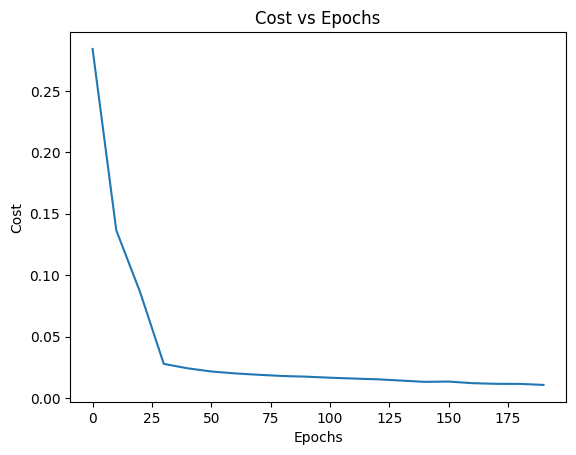

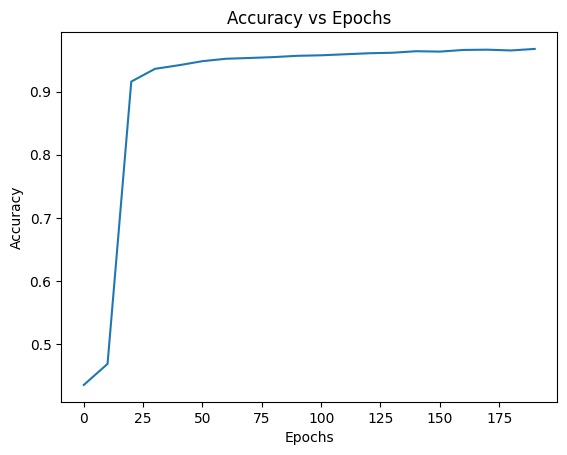

In [20]:
b1, W1, b2, W2, accuracy = training_data(X_train, Y_train, X_Validate, Y_Validate, epochs, alpha)

The accuracy of the validation set is around 95%

In [12]:
accuracy

96.1017976166431

And the model parameters are:

In [13]:
b1, W1, b2, W2

(array([ -1.20879816,  -2.31890562,  -5.69464449,  -4.11287925,
         -0.50318349,  -2.05513728,  -1.14467425,  -2.42138646,
         -4.43622851,   0.63378082,  -4.8365037 ,  -3.62258808,
          0.70082273,  -5.42958767, -10.37903416,  -3.81870453,
         -2.93411032,  -3.57072241,  -6.13875778,  -2.88154923,
         -1.82874738,  -0.2622434 ,   0.11556899,  -0.05138334,
         -1.30472677]),
 array([[ 1.62434536, -0.61175641, -0.52817175, ...,  0.90159072,
          0.50249434,  0.90085595],
        [-0.68372786, -0.12289023, -0.93576943, ...,  2.10025514,
          0.12015895,  0.61720311],
        [ 0.30017032, -0.35224985, -1.1425182 , ...,  0.16003707,
          0.87616892,  0.31563495],
        ...,
        [-0.32425465,  1.06686631, -0.37814658, ...,  0.3938322 ,
         -0.15137905, -0.41505414],
        [-0.85782245,  0.47026103, -0.71104247, ..., -0.91428204,
          0.80115669,  0.11465216],
        [-2.30445222,  1.69949757, -0.76992763, ..., -0.51091193,
   

Finally, we can save them for later prediction

In [14]:
np.save('hidden_weight.npy', W1)
np.save('hidden_bias.npy', b1)
np.save('output_weight.npy', W2)
np.save('output_bias.npy', b2)

# Conclusion

In [16]:
X_test = np.random.rand(1, n)
print(X_test.shape)
prediction = predict(X_test, b1, W1, b2, W2)
print(f"prediction = {prediction}")
print(f"X_test = {X_test}")

(1, 784)
prediction = [0 0 0 0]
X_test = [[6.02128142e-01 8.62859364e-01 6.17885986e-01 4.57209016e-02
  4.91627856e-01 4.95220404e-01 8.60226568e-01 7.33323778e-01
  9.43951753e-01 5.97909761e-01 1.98395608e-01 8.13332089e-01
  6.66243103e-01 6.57197110e-02 2.87594249e-01 8.94302379e-01
  4.20915670e-01 1.81189984e-01 4.94794323e-01 9.95699997e-01
  9.51245743e-01 9.58117031e-01 7.89246121e-01 2.24206212e-01
  2.90498443e-01 3.56378169e-01 5.96100189e-01 3.14755586e-01
  9.66690466e-01 3.08603366e-01 7.46113207e-01 6.50271521e-02
  9.43405950e-01 7.95064323e-01 8.48672484e-01 8.81184041e-02
  4.76102862e-01 2.70518600e-02 4.10366157e-01 5.92788264e-01
  5.38432421e-01 3.43927310e-01 1.06862197e-01 6.06358642e-01
  1.36387516e-01 6.05545094e-01 6.97435191e-01 5.41602178e-01
  3.87713602e-01 8.01177847e-01 6.96324941e-01 9.45285653e-01
  3.92263810e-01 3.92191660e-01 5.08980996e-01 8.19378006e-01
  7.40417455e-02 8.78471687e-01 9.07940776e-02 9.48665573e-01
  5.84246861e-01 5.76775705e-